In [1]:
import numpy as np 
import pandas as pd
import pickle
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path 
import re 
# get utils for thresholds
from src import util_analysis 
from src import util_process_prolific as util_process
import importlib
from tqdm.auto import tqdm
import multiprocessing as mp

/om2/user/imgriff/conda_envs/torch_11_cuda_11_pitch/lib/python3.9/site-packages/scipy/__init__.py:138: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.26.4)
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion} is required for this version of "


# Load pre-computed human threshold data

In [ ]:
path_to_human_results = Path('final_results_dir')

human_thresh_df = pd.read_pickle(path_to_human_results / 'summary_2024_human_threshold_results_avg_sex_cond.pdpkl')
human_thresh_df_per_sex = pd.read_pickle(path_to_human_results / 'summary_2024_human_threshold_results_split_by_sex_cond.pdpkl')

In [3]:
N = 33

In [4]:

human_thresh_df_summary = human_thresh_df.groupby(['elev_delta', 'azim_delta']).agg({'threshold':['mean', 'std']}).reset_index()
# # flatten multiindex
human_thresh_df_summary.columns = ['elev_delta', 'azim_delta', 'threshold', 'threshold_std']


human_thresh_df_summary_per_sex = human_thresh_df_per_sex.groupby(['elev_delta', 'azim_delta', 'sex_cond']).agg({'threshold':['mean', 'std']}).reset_index()
# # flatten multiindex
human_thresh_df_summary_per_sex.columns = ['elev_delta', 'azim_delta', 'sex_cond', 'threshold', 'threshold_std']


In [5]:
human_thresh_df_summary

,elev_delta,azim_delta,threshold,threshold_std
0,0,0,0.059140,0.486347
1,0,10,-2.814872,0.635813
2,0,60,-5.495252,0.640000
3,10,0,-1.474366,0.462032
4,60,0,-1.585866,0.504760


## Plot human thresholds

Text(0.5, 1.05, 'Huamn thresholds (N=33)')

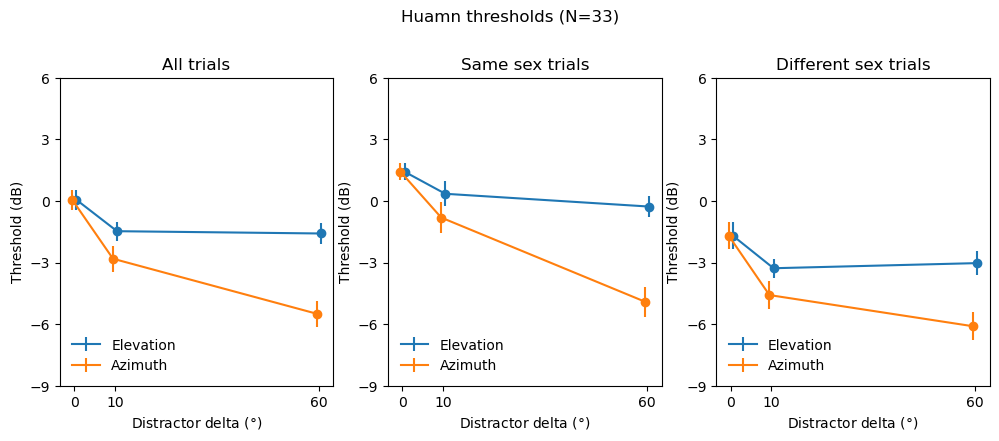

In [6]:
#### Per sex 
fig, ax = plt.subplots(1,3,figsize=(12,4))


sex_conds = ['all', 'same', 'different']
for ix, sex_cond in enumerate(sex_conds):
    if ix == 0:
        elev_data = human_thresh_df_summary[human_thresh_df_summary.azim_delta == 0]
        azim_data = human_thresh_df_summary[human_thresh_df_summary.elev_delta == 0]
        elev_to_plot = elev_data
        azim_to_plot = azim_data
    else: 
        elev_data = human_thresh_df_summary_per_sex[human_thresh_df_summary_per_sex.azim_delta == 0]
        azim_data = human_thresh_df_summary_per_sex[human_thresh_df_summary_per_sex.elev_delta == 0]
        elev_to_plot = elev_data[elev_data.sex_cond == sex_cond]
        azim_to_plot = azim_data[azim_data.sex_cond == sex_cond]

    ax[ix].errorbar(data=elev_to_plot, x=elev_to_plot.elev_delta + 0.5, y='threshold', yerr='threshold_std', fmt='o-', label='Elevation')
    ax[ix].errorbar(data=azim_to_plot, x=azim_to_plot.azim_delta - 0.5, y='threshold', yerr='threshold_std', fmt='o-', label='Azimuth')

    ax[ix].legend(loc='lower left', markerscale=0)
    ax[ix].get_legend().get_frame().set_linewidth(0.0)

    ax[ix].set_xlabel('Distractor delta ($\degree$)')
    ax[ix].set_ylabel('Threshold (dB)')
    ax[ix].set_xticks([0, 10, 60])
    ax[ix].set_yticks(np.arange(-9, 7, 3))
    if ix == 0:
        ax[ix].set_title("All trials")
    else:
        ax[ix].set_title(f"{sex_cond.title()} sex trials")

plt.suptitle(f"Huamn thresholds (N={N})", y=1.05)

## Load model data and meta files

In [7]:
room_manifest = pd.read_pickle('/om2/user/msaddler/spatial_audio_pipeline/assets/brir/eval/manifest_room.pdpkl')
# for tuple_ in room_manifest.itertuples():
#     print(tuple_)
#     break
room_material_map = {}
for row in room_manifest.itertuples():
    wall1 = row.material_x0[0].split(',')[0]
    wall2 = row.material_y1[0].split(',')[0]
    if wall1 == wall2:
        wall_str = f"{wall1} walls"
    else:
        wall_str = f"{wall1} and {wall2} walls"

    floor = row.material_z0[0].split(',')[0]
    ceiling = row.material_z1[0].split(',')[0]
    name_str = f"{wall_str} \n {floor} floor \n {ceiling} ceiling"

    if row.index_room in [5, 6]:
        name_str = 'Alternate speaker room'
    if row.index_room in [6, 8]:
        name_str += ' \n head rotated'
    else:
        head_rotated = ''
    if 'Anechoic' in name_str:
        name_str = "Anechoic"
    room_material_map[row.index_room] = name_str
# room_material_map = {row.index_room: f"{row.material_x0[0].split(',')[0]} and \n {row.material_y1[0].split(',')[0]} walls \n {row.material_z0[0].split(',')[0]} floor \n {row.material_z1[0].split(',')[0]} ceiling" for row in room_manifest.itertuples()}
# room_material_map[5] = 'standard speaker room'
room_material_map

{0: 'Anechoic',
 1: 'Wood panelling on glass fiber blanket walls \n Carpet on foam rubber padding floor \n Highly absorptive panels ceiling',
 2: 'Brick walls \n Wood parquet on concrete floor \n Plaster ceiling',
 3: 'Fiberglass wall treatment walls \n Linoleum floor \n Acoustic tiles ceiling',
 4: 'Concrete walls \n Linoleum floor \n Acoustic tiles ceiling',
 5: 'Alternate speaker room',
 6: 'Alternate speaker room \n head rotated',
 7: 'Fiberglass wall treatment walls \n Linoleum floor \n Acoustic tiles ceiling',
 8: 'Fiberglass wall treatment walls \n Linoleum floor \n Acoustic tiles ceiling \n head rotated'}

In [8]:
import pickle 

manifest_path = "binaural_test_manifests/human_array_exmpt_sim_v02_only_human_locs_w_noise_min_reverb_mit_room_v02.pkl"
with open(manifest_path, "rb") as f: 
    manifest = pickle.load(f)
    

In [9]:
manifest_df  = pd.DataFrame(manifest.values())
# manifest_df

In [10]:
# spkr_room_manifest = pd.read_pickle('/om2/user/msaddler/spatial_audio_pipeline/assets/brir/mit_bldg46room1004/manifest_room.pdpkl')
spkr_room_manifest = pd.read_pickle('/om2/user/imgriff/spatial_audio_pipeline/assets/brir/mit_bldg46room1004_min_reverb/manifest_room.pdpkl')

In [11]:

output_paths = list(Path(f"binaural_eval/simulate_2024_human_threshold_experiment_v02_30_dB_pink_noise_min_verb_mit46_1004").glob("*/*v10*.pkl"))
# output_paths = list(Path(f"binaural_eval/simulate_2024_human_threshold_experiment_v02_cue_noise").glob("*/*.pkl"))
stim_manifest_df = pd.read_pickle('/om/user/imgriff/datasets/human_word_rec_SWC_2024/full_cue_target_distractor_df_w_meta.pdpkl')


word_class_map = pickle.load( open("/om2/user/imgriff/datasets/commonvoice_9/en/cv_800_word_label_to_int_dict.pkl", "rb" )) 
ix_to_word = {v:k for k,v in word_class_map.items()}

remap_azim = lambda azim: 360 - azim if azim > 180 else 0 - azim 

results_dfs = []

    # output_paths = list(Path(f'swc_2024_eval_full_stim/{model_name}').glob('*.csv'))

# wanted_models = [
    
#     'word_task_half_co_loc_v09_gender_bal_4M_w_no_cue_learned_higher_lr_less_dropout',
#                  'word_task_v09_cue_loc_task',
#                 'word_task_v10_main_feature_gain_config',
                #  'word_task_v09_4MGB_ln_first_arch_1',
                # 'word_task_v09_4MGB_ln_first_arch_2',
                # 'word_task_v09_4MGB_ln_first_arch_4',
                # 'word_task_v09_4MGB_ln_first_arch_6',
                # 'word_task_v09_4MGB_ln_first_arch_7',
                # 'word_task_v09_4MGB_ln_first_arch_8',
                # 'word_task_v09_4MGB_ln_first_arch_9',
# ]

gend_map = {True:'same', False:'different'}

for path in output_paths:
    # if not any([model in path.stem for model in wanted_models]):
    #     continue
    # if not 'v09' in str(path):
    #     continue
    # if 'modulated' in path.stem:
    #     continue 
    # if not 'mitb46' in path.stem:
    #     continue 
    # if 'white_noise' in path.as_posix():
    #     continue
    # if 'texture' in path.as_posix():
    #     continue

    res_dict = pickle.load(open(path, 'rb'))
    to_track = {key:val for key,val in res_dict.items() if key != 'textures'}

    df = pd.DataFrame.from_dict(to_track)
    # break
    df.rename(columns={"results": "accuracy"}, inplace=True)
    df['model'] = path.parent.stem

    df.loc[df.index.values, ['word', 'distractor_word','sex_cond']] = stim_manifest_df.loc[df.stim_ix_list.values, ['word', 'distractor_word','sex_cond']].values
    df['target_word'] = df['true_word_int'].map(ix_to_word)
    df['pred_word'] = df['preds'].map(ix_to_word)
    df['correct'] = (df['true_word_int'] == df['preds']).astype('int')
    df['str_confusions'] = df[['pred_word', 'distractor_word']].apply(lambda x: 1 if x.pred_word in x.distractor_word else 0, axis=1)
    ## Get SNR level from path
    if 'clean' in path.stem:
        snr = 'clean'
    else:
        snr = int(re.search('(-?\d+)_SNR', path.stem).group(0).strip('_SNR'))
    df['snr'] = snr 
    ## Get texture leve lfrom path 
    if "no_texture" in path.stem:
        texture_level = 'no_texture'
    
    elif 'texture' in path.stem: 
        texture_level = re.search('(-?\d+)dB_bg_texture',path.stem).group(0).split('dB')[0]
    elif 'pink_noise' in path.stem:
        texture_level = re.search('(-?\d+)dB_bg_pink_noise',path.stem).group(0).split('dB')[0]


    df['texture_level'] = texture_level
    df["target_azim"], df["target_elev"] = path.stem.split('target_loc_')[1].split('_distract_loc_')[0].split('_')
    df["distractor_azim"], df["distractor_elev"] = path.stem.split('_distract_loc_')[1].split('_')[:2]
    # # map azim to 0-180
    df['target_azim'] = df['target_azim'].astype(int).apply(remap_azim)
    df['distractor_azim'] = df['distractor_azim'].astype(int).apply(remap_azim)
    df['target_elev'] = df['target_elev'].astype(int)
    df['distractor_elev'] = df['distractor_elev'].astype(int)
    df['room_ix'] = int(re.search('room(-?\d+)', path.stem).group(0).strip('room'))
    df['room_type'] = re.search('SNR_(.*?)_room', path.stem).group(0).split('SNR_')[-1].split("_room")[0]
    df['n_distractors'] = 1 if '1_distractor' in path.stem else 2
    df['test_set'] = 'all_stim' if 'all_stim' in path.stem else 'subset'
    # if 'white_noise' in path.as_posix():
    #     df['distractor_type'] = 'white_noise'
    # elif 'texture' in path.as_posix():
    #     df['distractor_type'] = 'texture'
    # else:
    # df['distractor_type'] = 'speech'
    results_dfs.append(df)

results = pd.concat(results_dfs)

In [12]:
results.loc[results.room_type.str.contains('eval'), 'room_str'] = results.loc[results.room_type == 'eval', 'room_ix'].map(room_material_map)

results.loc[results.room_type.str.contains('mitb46'), 'room_str'] = 'Normal speaker array'
results.loc[results.room_type.str.contains('mitb46'), 'room_ix'] = 9 # use n from diff room notebook

results.loc[results.room_type.str.contains('reverb'), 'room_str'] = 'Min. reverb speaker array'
results.loc[results.room_type.str.contains('reverb'), 'room_ix'] = 10 # use n from diff room notebook

In [13]:
grouped_model_results = results.groupby(['model', 'target_azim', 'target_elev', 'distractor_azim', 'test_set',  'texture_level',
                                   'distractor_elev', 'sex_cond', 'snr', 'n_distractors', 'room_str']).agg({'accuracy':['mean', 'sem'],
                                                                                                                     'confusions':['mean', 'sem']}).reset_index()
# flatten multiindex
grouped_model_results.columns = ['_'.join(col).strip() for col in grouped_model_results.columns.values]
# remove trailing underscore
grouped_model_results.columns = [col[:-1] if col[-1] == '_' else col for col in grouped_model_results.columns.values]



In [14]:
grouped_model_results['distractor_elev_delta'] = (grouped_model_results['target_elev'] - grouped_model_results['distractor_elev']).abs()

In [15]:
grouped_model_results.texture_level.unique()

array(['30'], dtype=object)

<Figure size 640x480 with 0 Axes>

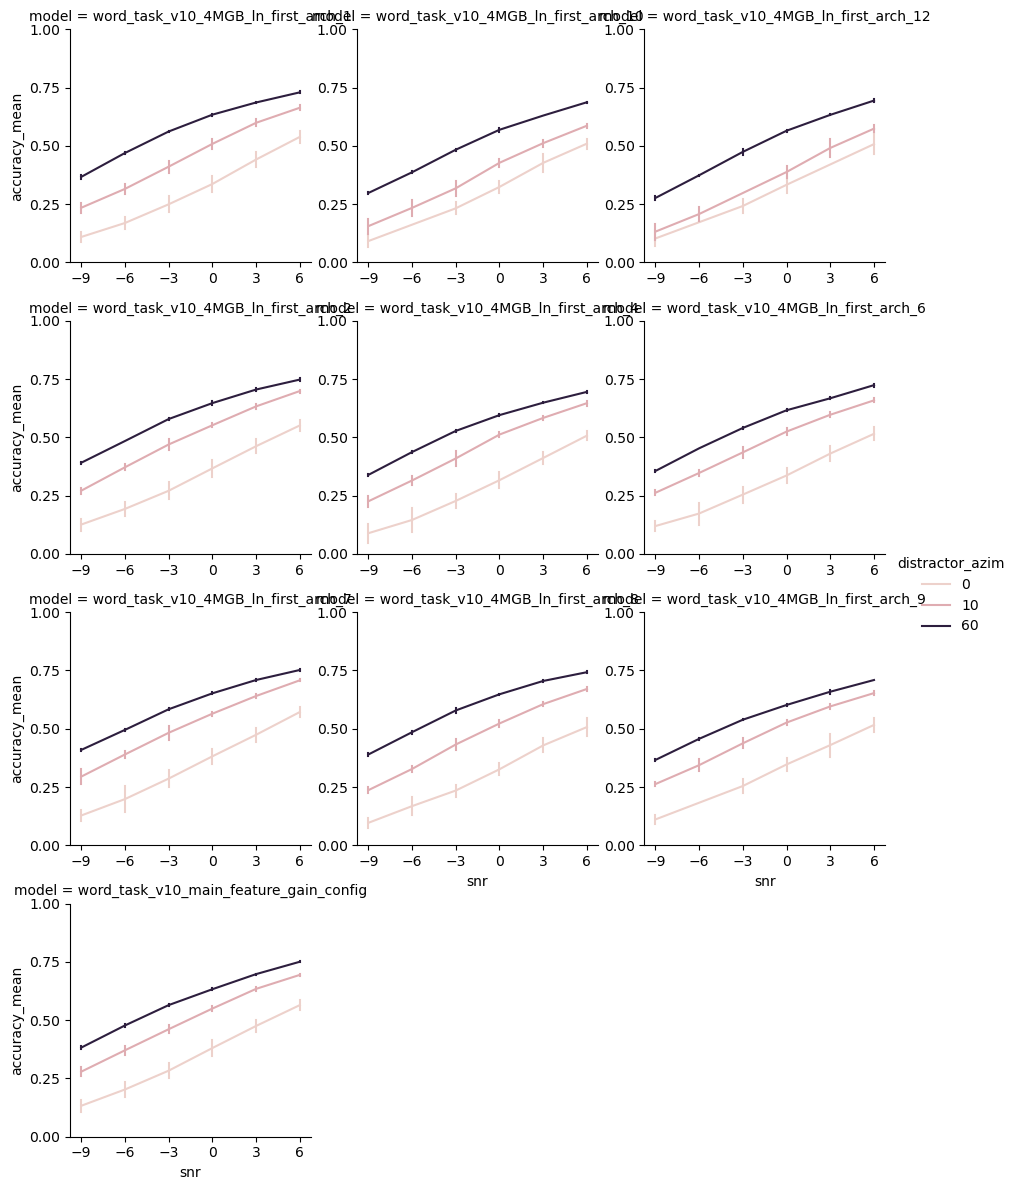

In [16]:
to_plot = grouped_model_results[
                        (grouped_model_results.distractor_elev_delta.eq(0 ))
                            & (grouped_model_results.distractor_azim.abs().isin([0,10, 60])) 
                            ].copy()

to_plot.distractor_azim = to_plot.distractor_azim.abs()                    


azim_thresholds = []
# p0 = [0.0, -4, 4]


plt.figure()
g = sns.relplot(data=to_plot[to_plot.snr.isin([6,3, 0, -3, -6, -9,])],
                                x='snr', y='accuracy_mean', hue="distractor_azim",
                                kind='line', legend='full', facet_kws={"sharey":False, "sharex":False},
                                # col='texture_level',#  col_order=col_order,
                                col='model', col_wrap=3,
                                # row='room_str',
                                # palette=palette, 
                                errorbar=('se', 1),
                                err_style='bars',
                                height=3, aspect=1)
g.set(xticks=np.arange(-9, 7, 3), yticks=[0, 0.25, 0.5, 0.75, 1])


<Figure size 640x480 with 0 Axes>

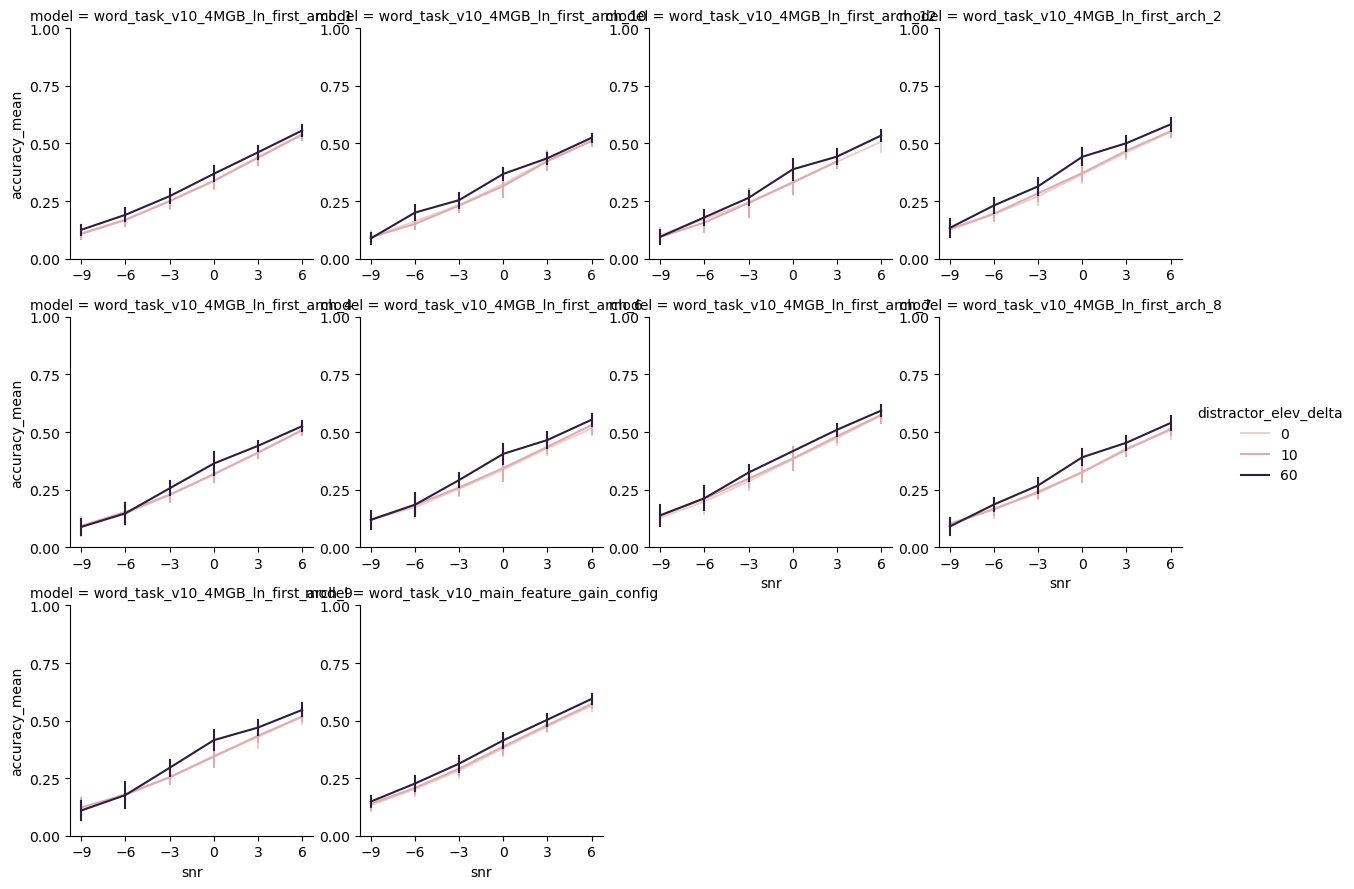

In [18]:
to_plot = grouped_model_results[
                        (grouped_model_results.distractor_azim.eq(0 ))
                            # & (grouped_model_results.distractor_azim.abs().isin([0,10, 60])) 
                            ].copy()

to_plot.distractor_azim = to_plot.distractor_azim.abs()                    


azim_thresholds = []
# p0 = [0.0, -4, 4]


plt.figure()
g = sns.relplot(data=to_plot[to_plot.snr.isin([6,3, 0, -3, -6, -9,])],
                                x='snr', y='accuracy_mean', hue="distractor_elev_delta",
                                kind='line', legend='full', facet_kws={"sharey":False, "sharex":False},
                                col='model', col_wrap=4,#  col_order=col_order,
                                # row='room_str',
                                # palette=palette, 
                                errorbar=('se', 1),
                                err_style='bars',
                                height=3, aspect=1)
g.set(xticks=np.arange(-9, 7, 3), yticks=[0, 0.25, 0.5, 0.75, 1])


In [19]:
grouped_model_results['azim_delta'] = (grouped_model_results['distractor_azim'] - grouped_model_results['target_azim']).abs()
grouped_model_results['elev_delta'] = (grouped_model_results['distractor_elev'] - grouped_model_results['target_elev']).abs()

In [ ]:
## Fit model thresholds per texture level 
np.random.seed(0)
n_boots = 1_000  ## use 10_000 for final analysis

model_thresholds = []

### Bootstrap over alt archs 

n_models = grouped_model_results.model.nunique()

for (dist_azim, dist_elev), data in grouped_model_results.groupby(['azim_delta', 'elev_delta']):
    for i in tqdm(range(n_boots)):
        model_sample  = np.random.choice(grouped_model_results.model.unique(), size=n_models, replace=True)
        sample_data = pd.concat([data[data.model == model] for model in model_sample], axis=0, ignore_index=True).reset_index()
        results_for_thresh = sample_data.groupby('snr').agg({'accuracy_mean':'mean'}).reset_index()
        # try:
        thresh, poly = util_analysis.estimate_threshold_poly(results_for_thresh.snr.values, results_for_thresh.accuracy_mean.values, degree=2)
        # except:
            # thresh = 6 # set to max snr tested
        model_thresholds.append({
                        'texture_level':texture_level, 'azim_delta':dist_azim, 'elev_delta':dist_elev, "sex_cond":sex_cond,
                        'threshold':thresh})

model_thresh_df = pd.DataFrame(model_thresholds)

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

In [ ]:
model_thresh_df

NameError: name 'model_thresh_df' is not defined

In [21]:
# ## Fit model thresholds per texture level for control models 
# np.random.seed(0)
# n_boots = 1_000  ## use 10_000 for final analysis


# model_thresholds = []

# for (model, texture_level, dist_azim, dist_elev), data in grouped_model_results.groupby(['model', 'texture_level', 'azim_delta', 'elev_delta']):
#     for i in tqdm(range(n_boots)):
#         boot_data = data.sample(frac=1, replace=True)
#         results_for_thresh = boot_data.groupby('snr').agg({'accuracy_mean':'mean'}).reset_index()
#         try:
#             thresh, poly = util_analysis.estimate_threshold_poly(results_for_thresh.snr.values, results_for_thresh.accuracy_mean.values, degree=2)
#         except:
#             thresh = np.nan
#         model_thresholds.append({
#                         'model':model, 'texture_level':texture_level, 'azim_delta':dist_azim, 'elev_delta':dist_elev,
#                         'threshold':thresh})


# model_thresh_df = pd.DataFrame(model_thresholds)

In [30]:
grouped_model_results.model.unique()

array(['word_task_v10_4MGB_ln_first_arch_1',
       'word_task_v10_4MGB_ln_first_arch_10',
       'word_task_v10_4MGB_ln_first_arch_12',
       'word_task_v10_4MGB_ln_first_arch_2',
       'word_task_v10_4MGB_ln_first_arch_4',
       'word_task_v10_4MGB_ln_first_arch_6',
       'word_task_v10_4MGB_ln_first_arch_7',
       'word_task_v10_4MGB_ln_first_arch_8',
       'word_task_v10_4MGB_ln_first_arch_9',
       'word_task_v10_main_feature_gain_config'], dtype=object)

In [32]:
## Fit model thresholds per texture level 
np.random.seed(0)
n_boots = 1_000  ## use 10_000 for final analysis

model_thresholds = []

### Bootstrap over alt archs 

n_models = grouped_model_results.model.nunique()

for (dist_azim, dist_elev), data in grouped_model_results.groupby(['azim_delta', 'elev_delta']):
    for i in tqdm(range(n_boots)):
        model_sample  = np.random.choice(grouped_model_results.model.unique(), size=n_models, replace=True)
        sample_data = pd.concat([data[data.model == model] for model in model_sample], axis=0, ignore_index=True).reset_index()
        results_for_thresh = sample_data.groupby('snr').agg({'accuracy_mean':'mean'}).reset_index()
        # try:
        thresh, poly = util_analysis.estimate_threshold_poly(results_for_thresh.snr.values, results_for_thresh.accuracy_mean.values, degree=2)
        # except:
            # thresh = 6 # set to max snr tested
        model_thresholds.append({
                        'model':model, 'texture_level':texture_level, 'azim_delta':dist_azim, 'elev_delta':dist_elev, "sex_cond":sex_cond,
                        'threshold':thresh})

model_thresh_df = pd.DataFrame(model_thresholds)

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

In [33]:
model_thresh_df

,model,texture_level,azim_delta,elev_delta,sex_cond,threshold
0,word_task_v10_4MGB_ln_first_arch_12,30,0,0,all,4.813814
1,word_task_v10_4MGB_ln_first_arch_12,30,0,0,all,4.348348
2,word_task_v10_4MGB_ln_first_arch_12,30,0,0,all,4.753754
3,word_task_v10_4MGB_ln_first_arch_12,30,0,0,all,4.603604
4,word_task_v10_4MGB_ln_first_arch_12,30,0,0,all,4.663664
...,...,...,...,...,...,...
4995,word_task_v10_4MGB_ln_first_arch_12,30,60,0,all,-4.990991
4996,word_task_v10_4MGB_ln_first_arch_12,30,60,0,all,-4.435435
4997,word_task_v10_4MGB_ln_first_arch_12,30,60,0,all,-5.126126
4998,word_task_v10_4MGB_ln_first_arch_12,30,60,0,all,-3.789790


In [34]:

model_thresh_df_summary = model_thresh_df.groupby(['elev_delta', 'azim_delta']).agg({'threshold':['mean', 'std']}).reset_index()
# # flatten multiindex
model_thresh_df_summary.columns = ['elev_delta', 'azim_delta', 'threshold', 'threshold_std']


# model_thresh_df_summary_per_sex = model_thresh_df_sex_cond.groupby(['model', 'elev_delta', 'azim_delta', 'sex_cond']).agg({'threshold':['mean', 'std']}).reset_index()
# # # flatten multiindex
# model_thresh_df_summary_per_sex.columns = ['model', 'elev_delta', 'azim_delta', 'sex_cond', 'threshold', 'threshold_std']


#### Plot main human v model 

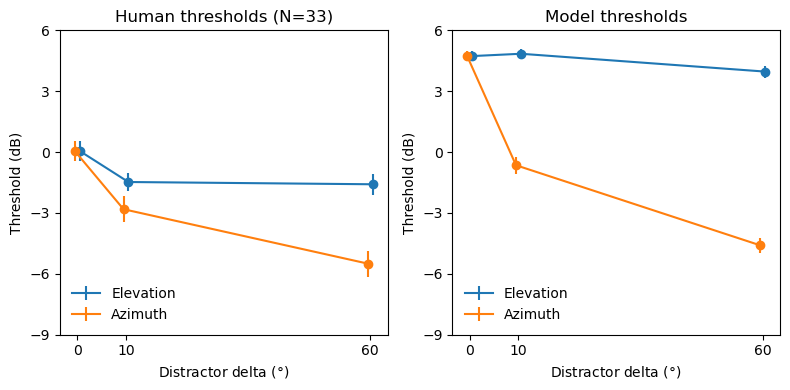

In [37]:
#### Per sex 
fig, axs = plt.subplots(1,2,figsize=(8,4))


for ix, ax in enumerate(axs):
    if ix == 0:
        elev_data = human_thresh_df_summary[human_thresh_df_summary.azim_delta == 0]
        azim_data = human_thresh_df_summary[human_thresh_df_summary.elev_delta == 0]
    elif ix == 1: 
        elev_data = model_thresh_df_summary[(model_thresh_df_summary.azim_delta == 0)] #& (model_thresh_df_summary.model.str.contains('v10'))]
        azim_data = model_thresh_df_summary[(model_thresh_df_summary.elev_delta == 0)]# & (model_thresh_df_summary.model.str.contains('v10'))]
    elev_to_plot = elev_data
    azim_to_plot = azim_data
  
    ax.errorbar(data=elev_to_plot, x=elev_to_plot.elev_delta + 0.5, y='threshold', yerr='threshold_std', fmt='o-', label='Elevation')
    ax.errorbar(data=azim_to_plot, x=azim_to_plot.azim_delta - 0.5, y='threshold', yerr='threshold_std', fmt='o-', label='Azimuth')

    ax.legend(loc='lower left', markerscale=0)
    ax.get_legend().get_frame().set_linewidth(0.0)

    ax.set_xlabel('Distractor delta ($\degree$)')
    ax.set_ylabel('Threshold (dB)')
    ax.set_xticks([0, 10, 60])
    ax.set_yticks(np.arange(-9, 7, 3))
    if ix == 0:
        ax.set_title(f"Human thresholds (N={N})" )
    elif ix == 1:
        ax.set_title("Model thresholds" )

plt.tight_layout()

In [38]:
model_thresh_df_summary

,elev_delta,azim_delta,threshold,threshold_std
0,0,0,4.731021,0.242195
1,0,10,-0.648634,0.427399
2,0,60,-4.594880,0.369980
3,10,0,4.845721,0.256185
4,60,0,3.966937,0.291467


AttributeError: 'DataFrame' object has no attribute 'model'

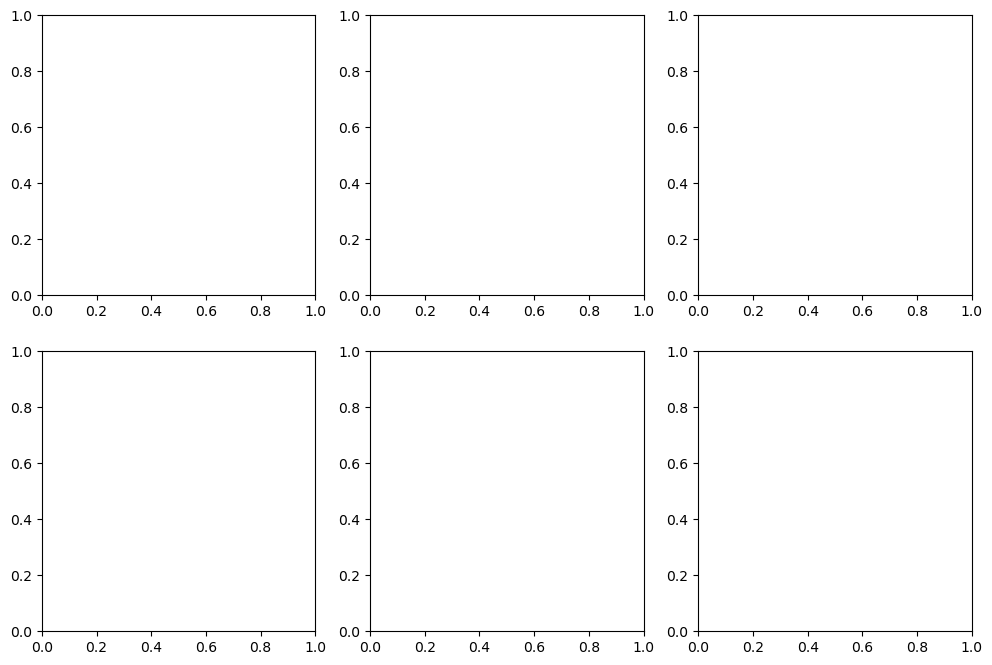

In [39]:
#### Per sex 
fig, ax = plt.subplots(2,3,figsize=(12,8))


sex_conds = ['all', 'same', 'different']
for jx, model in enumerate(model_thresh_df_summary.model.unique()):
    for ix, sex_cond in enumerate(sex_conds):
        if ix == 0:
            elev_data = model_thresh_df_summary[(model_thresh_df_summary.azim_delta == 0) & (model_thresh_df_summary.model == model)]
            azim_data = model_thresh_df_summary[(model_thresh_df_summary.elev_delta == 0) & (model_thresh_df_summary.model == model)]
            elev_to_plot = elev_data
            azim_to_plot = azim_data
        else: 
            elev_data = model_thresh_df_summary_per_sex[(model_thresh_df_summary_per_sex.azim_delta == 0)  & (model_thresh_df_summary_per_sex.model == model)]
            azim_data = model_thresh_df_summary_per_sex[(model_thresh_df_summary_per_sex.elev_delta == 0)  & (model_thresh_df_summary_per_sex.model == model)]
            elev_to_plot = elev_data[elev_data.sex_cond == sex_cond]
            azim_to_plot = azim_data[azim_data.sex_cond == sex_cond]

        ax[jx, ix].errorbar(data=elev_to_plot, x=elev_to_plot.elev_delta + 0.5, y='threshold', yerr='threshold_std', fmt='o-', label='Elevation')
        ax[jx, ix].errorbar(data=azim_to_plot, x=azim_to_plot.azim_delta - 0.5, y='threshold', yerr='threshold_std', fmt='o-', label='Azimuth')

        ax[jx, ix].legend(loc='lower left', markerscale=0)
        ax[jx, ix].get_legend().get_frame().set_linewidth(0.0)

        ax[jx, ix].set_xlabel('Distractor delta ($\degree$)')
        ax[jx, ix].set_ylabel('Threshold (dB)')
        ax[jx, ix].set_xticks([0, 10, 60])
        ax[jx, ix].set_yticks(np.arange(-9, 7, 3))
        if ix == 0:
            ax[jx, ix].set_title(f"{model}\nAll trials")
        else:
            ax[jx, ix].set_title(f"{model}\n{sex_cond.title()} sex trials")

    plt.suptitle(f"Model thresholds", y=1.01)
plt.tight_layout()

### Look at accuracy v snr traces:


In [ ]:
good_part_results = pd.read_csv('final_results_dir/human_threshold_raw_data_N-33.csv')
good_part_results.head()

,participant,target_azim,target_elev,distractor_azim,distractor_elev_delta,snr,n_distractors,correct_mean,correct_sem,confusions_mean,confusions_sem,confusions_count
0,participant_001,0,40,-60,0,-9,2,0.1875,0.100778,0.5625,0.128087,16
1,participant_001,0,40,-60,0,-6,2,0.3125,0.119678,0.2500,0.111803,16
2,participant_001,0,40,-60,0,-3,2,0.4375,0.128087,0.0625,0.062500,16
3,participant_001,0,40,-60,0,0,2,0.5625,0.128087,0.0000,0.000000,16
4,participant_001,0,40,-60,0,3,2,0.8750,0.085391,0.0000,0.000000,16


In [ ]:
# put humans and model in same dataframe. Change correct to accuracy in column names 
grouped_model_results.rename(columns={'accuracy_mean':'correct_mean', 'accuracy_sem':'correct_sem',}, inplace=True)
grouped_model_results_to_merge = grouped_model_results.copy()
good_part_results.rename(columns={'azim_delta':'distractor_azim', 'elev_delta':'distractor_elev_delta'}, inplace=True)


grouped_model_results['group'] = grouped_model_results['model']
N = good_part_results.participant.nunique()
good_part_results['group'] = f'Humans (N={N})'



merged_results = pd.concat([grouped_model_results, good_part_results], ignore_index=True, axis=0)

# N = good_part_results.participant.nunique()
# good_part_results['group'] = f'Humans (N={N})'
# merged_results = pd.concat([grouped_model_results, good_part_results], ignore_index=True, axis=0)



# N = good_part_results.participant.nunique()
# good_part_results['group'] = f'Humans (N={N})'


# merged_good_parts = merged_results[merged_results.participant.isin(good_parts)]

In [ ]:
merged_results.group.unique()

array(['word_task_v09_cue_loc_task',
       'word_task_v10_main_feature_gain_config', 'Humans (N=33)'],
      dtype=object)

In [ ]:
to_plot

,model,target_azim,target_elev,distractor_azim,test_set,texture_level,distractor_elev,sex_cond,snr,n_distractors,room_str,accuracy_mean,accuracy_sem,confusions_mean,confusions_sem,distractor_elev_delta
24,word_task_v09_cue_loc_task,0,-20,0,all_stim,30,-20,different,-9,2,Min. reverb speaker array,0.091189,0.009219,0.171107,0.012061,0
25,word_task_v09_cue_loc_task,0,-20,0,all_stim,30,-20,different,-6,2,Min. reverb speaker array,0.149590,0.011423,0.131148,0.010811,0
26,word_task_v09_cue_loc_task,0,-20,0,all_stim,30,-20,different,-3,2,Min. reverb speaker array,0.237705,0.013633,0.092213,0.009266,0
27,word_task_v09_cue_loc_task,0,-20,0,all_stim,30,-20,different,0,2,Min. reverb speaker array,0.329918,0.015058,0.066598,0.007985,0
28,word_task_v09_cue_loc_task,0,-20,0,all_stim,30,-20,different,3,2,Min. reverb speaker array,0.424180,0.015828,0.044057,0.006572,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
233,word_task_v10_main_feature_gain_config,0,40,0,all_stim,30,40,same,-6,2,Min. reverb speaker array,0.143443,0.011226,0.263320,0.014105,0
234,word_task_v10_main_feature_gain_config,0,40,0,all_stim,30,40,same,-3,2,Min. reverb speaker array,0.233607,0.013551,0.197746,0.012756,0
235,word_task_v10_main_feature_gain_config,0,40,0,all_stim,30,40,same,0,2,Min. reverb speaker array,0.314549,0.014871,0.139344,0.011091,0
236,word_task_v10_main_feature_gain_config,0,40,0,all_stim,30,40,same,3,2,Min. reverb speaker array,0.428279,0.015847,0.087090,0.009030,0


Text(0.5, 1.05, 'Azimuth performance')

<Figure size 640x480 with 0 Axes>

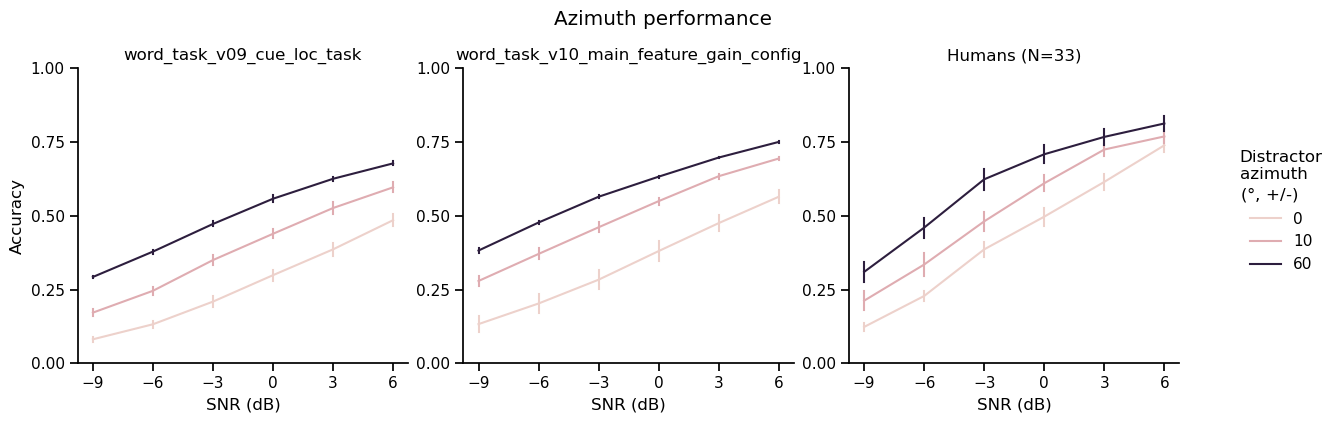

In [ ]:


## First, get grand average. Then bootstrap for error 
sns.set_context('notebook')

# avg threshold estimates for 0 and 10 azimuth separation 
to_plot = merged_results[
                                        # (merged_results.n_distractors == 2)
                                                #   & (merged_results.room_str == 'Min. reverb speaker array')
                                                (merged_results.distractor_elev_delta.eq(0 ))
                                                 & (merged_results.distractor_azim.abs().isin([0,10, 60])) 
                                                #   & (merged_results.snr.isin([6,3, 0, -3, -6, -9,]))
                                                    ].copy()

to_plot.distractor_azim = to_plot.distractor_azim.abs()                    
azim_results_for_thresh = to_plot.groupby(['model','room_str', 'distractor_azim', 'snr']).agg({'correct_mean':'mean'}).reset_index()



azim_thresholds = []
# p0 = [0.0, -4, 4]
# for (model, room, dist_type, azim), group in azim_results_for_thresh.groupby(['model', 'room_str', 'distractor_type', 'distractor_azim']): #, 'gender_cond']):
#     thresh, fit_popt, _ = util_analysis.estimate_thresholds(group.snr.values, group.correct_mean.values, bounds_from_data=True)#, p0=p0)
#     if np.isnan(thresh):
#         print(f"Threshold is nan for azim {azim}")
#     azim_thresholds.append({'model': model, "room":room, "dist_type":dist_type, 'azim': azim, 'threshold':thresh}) #  'gender_cond':gend_cond,
        
# azim_thresh_df = pd.DataFrame(azim_thresholds)

# col_order = [f'Humans (N={N})', "Model"]

plt.figure()
g = sns.relplot(data=to_plot[to_plot.snr.isin([6,3, 0, -3, -6, -9,])],
                                x='snr', y='correct_mean', hue="distractor_azim",
                                kind='line', legend='full', facet_kws={"sharey":False, "sharex":False},
                                col='group', #col_order=col_order,
                                # row='room_str',
                                # palette=palette, 
                                errorbar=('se', 1),
                                err_style='bars',
                                height=4, aspect=1)

g.set_axis_labels("SNR (dB)", "Accuracy")
# set legend title 
new_title = 'Distractor\nazimuth\n($\degree$, +/-)'
g._legend.set_title(new_title)
# set xticks from -9 to 6
g.set(xticks=np.arange(-9, 7, 3), yticks=[0, 0.25, 0.5, 0.75, 1])
# column titles 
g.set_titles("{col_name}")
plt.suptitle(f'Azimuth performance', y=1.05)
# plt.tight_layout()

<Figure size 640x480 with 0 Axes>

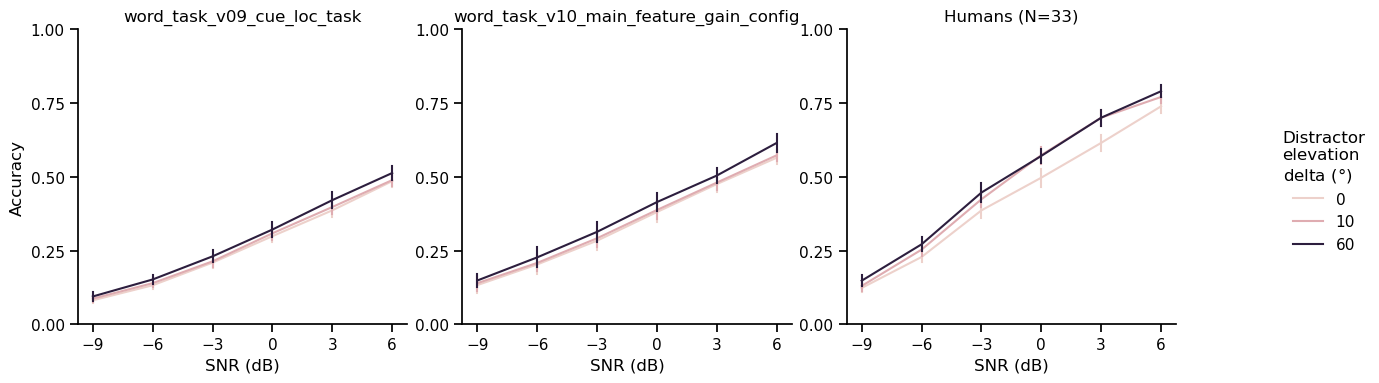

In [ ]:
to_plot = merged_results[
                    (merged_results.n_distractors == 2)
                        #   & (merged_results.room_str == 'Min. reverb speaker array')
                        # & (merged_results.distractor_elev_delta.isin([0,10,60]))
                        &	(merged_results.distractor_azim == 0) 
                        &	(merged_results.target_elev != 0) 

                        #   & (merged_results.snr.isin([6,3, 0, -3, -6, -9,]))
                          ].copy()

# to_plot.distractor_azim = to_plot.distractor_azim.abs()                    
# azim_results_for_thresh = to_plot.groupby(['model','room_str', 'distractor_azim', 'distractor_type', 'snr']).agg({'correct_mean':'mean'}).reset_index()



# azim_thresholds = []
# p0 = [0.0, -4, 4]
# for (model, room, dist_type, azim), group in azim_results_for_thresh.groupby(['model', 'room_str', 'distractor_type', 'distractor_azim']): #, 'gender_cond']):
#     thresh, fit_popt, _ = util_analysis.estimate_thresholds(group.snr.values, group.correct_mean.values, bounds_from_data=True)#, p0=p0)
#     if np.isnan(thresh):
#         print(f"Threshold is nan for azim {azim}")
#     azim_thresholds.append({'model': model, "room":room, "dist_type":dist_type, 'azim': azim, 'threshold':thresh}) #  'gender_cond':gend_cond,
    
# azim_thresh_df = pd.DataFrame(azim_thresholds)


plt.figure()
g = sns.relplot(data=to_plot[to_plot.snr.isin([6,3, 0, -3, -6, -9,])],
                x='snr', y='correct_mean', hue="distractor_elev_delta",
                kind='line', legend='full', facet_kws={"sharey":False, "sharex":False},
                col='group', 
                # row='room_str',
                # palette=palette, 
                errorbar=('se', 1),
                err_style='bars',
                height=4, aspect=1)
g.set_axis_labels("SNR (dB)", "Accuracy")
# set legend title 
new_title = 'Distractor\nelevation\ndelta ($\degree$)'
g._legend.set_title(new_title)
# set xticks from -9 to 6
g.set(xticks=np.arange(-9, 7, 3), yticks=[0, 0.25, 0.5, 0.75, 1])
# column titles 
g.set_titles("{col_name}")
# plt.suptitle(f'Model elevation performance', y=1.05)

<Figure size 640x480 with 0 Axes>

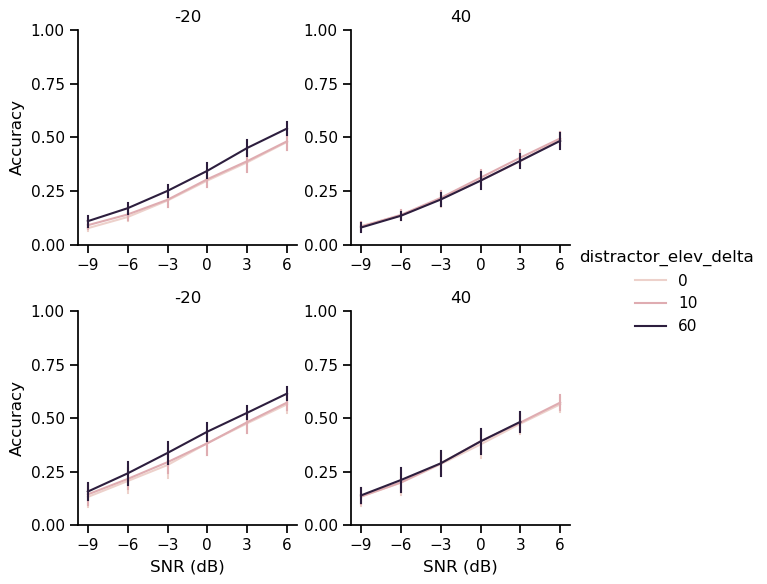

In [ ]:
to_plot = merged_results[
                    (merged_results.n_distractors == 2)
                    & (merged_results.group != 'Humans (N=33)')
                        #   & (merged_results.room_str == 'Min. reverb speaker array')
                        # & (merged_results.distractor_elev_delta.isin([0,10,60]))
                    &	(merged_results.distractor_azim == 0) 
                    &	(merged_results.target_elev != 0) 

                        #   & (merged_results.snr.isin([6,3, 0, -3, -6, -9,]))
                          ].copy()

# to_plot.distractor_azim = to_plot.distractor_azim.abs()                    
# azim_results_for_thresh = to_plot.groupby(['model','room_str', 'distractor_azim', 'distractor_type', 'snr']).agg({'correct_mean':'mean'}).reset_index()



# azim_thresholds = []
# p0 = [0.0, -4, 4]
# for (model, room, dist_type, azim), group in azim_results_for_thresh.groupby(['model', 'room_str', 'distractor_type', 'distractor_azim']): #, 'gender_cond']):
#     thresh, fit_popt, _ = util_analysis.estimate_thresholds(group.snr.values, group.correct_mean.values, bounds_from_data=True)#, p0=p0)
#     if np.isnan(thresh):
#         print(f"Threshold is nan for azim {azim}")
#     azim_thresholds.append({'model': model, "room":room, "dist_type":dist_type, 'azim': azim, 'threshold':thresh}) #  'gender_cond':gend_cond,
    
# azim_thresh_df = pd.DataFrame(azim_thresholds)


plt.figure()
g = sns.relplot(data=to_plot[to_plot.snr.isin([6,3, 0, -3, -6, -9,])],
                x='snr', y='correct_mean', hue="distractor_elev_delta",
                kind='line', legend='full', facet_kws={"sharey":False, "sharex":False},
                col='target_elev', 
                row='group',
                # palette=palette, 
                errorbar=('se', 1),
                err_style='bars',
                height=3, aspect=1)
g.set_axis_labels("SNR (dB)", "Accuracy")
# set legend title 
new_title = 'Distractor\nelevation\ndelta ($\degree$)'
# g._legend.set_title(new_title)
# set xticks from -9 to 6
g.set(xticks=np.arange(-9, 7, 3), yticks=[0, 0.25, 0.5, 0.75, 1])
# column titles 
g.set_titles("{col_name}")
# plt.suptitle(f'Model elevation performance', y=1.05)

<Figure size 640x480 with 0 Axes>

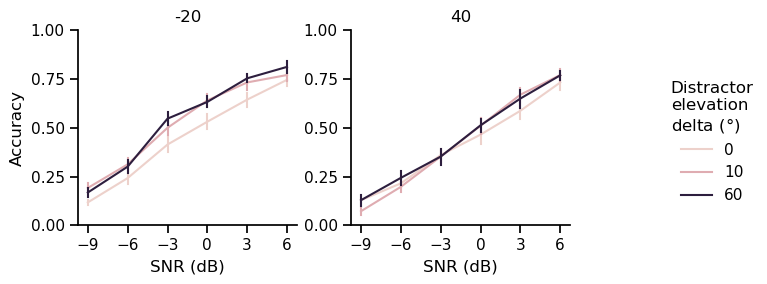

In [ ]:
to_plot = merged_results[
                    (merged_results.n_distractors == 2)
                    & (merged_results.group.str.contains('Human'))
                        #   & (merged_results.room_str == 'Min. reverb speaker array')
                        # & (merged_results.distractor_elev_delta.isin([0,10,60]))
                        &	(merged_results.distractor_azim == 0) 
                        #   & (merged_results.snr.isin([6,3, 0, -3, -6, -9,]))
                          ].copy()

# to_plot.distractor_azim = to_plot.distractor_azim.abs()                    
# azim_results_for_thresh = to_plot.groupby(['model','room_str', 'distractor_azim', 'distractor_type', 'snr']).agg({'correct_mean':'mean'}).reset_index()



# azim_thresholds = []
# p0 = [0.0, -4, 4]
# for (model, room, dist_type, azim), group in azim_results_for_thresh.groupby(['model', 'room_str', 'distractor_type', 'distractor_azim']): #, 'gender_cond']):
#     thresh, fit_popt, _ = util_analysis.estimate_thresholds(group.snr.values, group.correct_mean.values, bounds_from_data=True)#, p0=p0)
#     if np.isnan(thresh):
#         print(f"Threshold is nan for azim {azim}")
#     azim_thresholds.append({'model': model, "room":room, "dist_type":dist_type, 'azim': azim, 'threshold':thresh}) #  'gender_cond':gend_cond,
    
# azim_thresh_df = pd.DataFrame(azim_thresholds)


plt.figure()
g = sns.relplot(data=to_plot[to_plot.snr.isin([6,3, 0, -3, -6, -9,])],
                x='snr', y='correct_mean', hue="distractor_elev_delta",
                kind='line', legend='full', facet_kws={"sharey":False, "sharex":False},
                col='target_elev', 
                # row='room_str',
                # palette=palette, 
                errorbar=('se', 1),
                err_style='bars',
                height=3, aspect=1)
g.set_axis_labels("SNR (dB)", "Accuracy")
# set legend title 
new_title = 'Distractor\nelevation\ndelta ($\degree$)'
g._legend.set_title(new_title)
# set xticks from -9 to 6
g.set(xticks=np.arange(-9, 7, 3), yticks=[0, 0.25, 0.5, 0.75, 1])
# column titles 
g.set_titles("{col_name}")
# plt.suptitle(f'Model elevation performance', y=1.05)